# Script utilisé pour la création du dataset

In [88]:
# import os

# # Répertoire contenant les images
# image_dirs = {
#     'train': 'dataset/images/train',
#     'val': 'dataset/images/val'
# }

# # Dictionnaire pour mapper les noms de dossiers aux classes
# class_map = {
#     '1': 1,
#     '2': 2,
#     '3': 3,
#     '4': 4,
#     '5': 5,
#     '6': 6,
#     '7': 7,
#     '8': 8,
#     '9': 9
# }

# # Créer les annotations
# for split, image_dir in image_dirs.items():
#     label_dir = f'dataset/labels/{split}'
#     if not os.path.exists(label_dir):
#         os.makedirs(label_dir)
    
#     for folder in os.listdir(image_dir):
#         class_id = class_map[folder]
#         folder_path = os.path.join(image_dir, folder)
        
#         for img_file in os.listdir(folder_path):
#             if img_file.endswith('.png'):
#                 annotation_path = os.path.join(label_dir, img_file.replace('.png', '.txt'))
#                 with open(annotation_path, 'w') as f:
#                     # Annotation standardisée pour un chiffre centré
#                     f.write(f'{class_id - 1} 0.5 0.5 0.8 0.8\n')
#                 # Déplacer l'image dans le répertoire principal
#                 os.rename(os.path.join(folder_path, img_file), os.path.join(image_dir, img_file))

# # Nettoyer les anciens répertoires
# for split in image_dirs:
#     for folder in class_map:
#         folder_path = os.path.join(image_dirs[split], folder)
#         if os.path.exists(folder_path):
#             os.rmdir(folder_path)


# Détection des contours de l'image, image binaire et découpage des cases

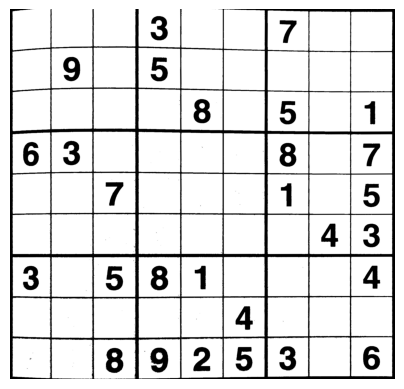

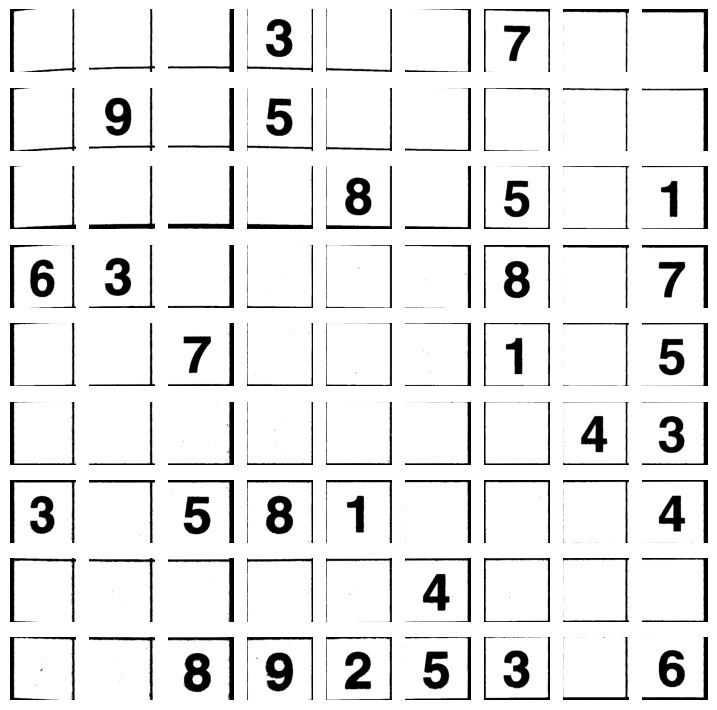

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def plot_image(image, title=None):
    """
    Affiche une image en utilisant matplotlib.
    
    :param image: Image chargée avec OpenCV.
    :param title: Titre optionnel pour l'image.
    """
    # Convertir l'image de BGR à RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Afficher l'image
    plt.imshow(image_rgb)
    if title:
        plt.title(title)
    plt.axis('off')  # Optionnel : cacher les axes
    plt.show()

def preprocess_image(img):
    blurred = cv2.GaussianBlur(img, (9, 9), 0)
    edges = cv2.Canny(blurred, 50, 100)
    return edges

def find_largest_contour(edges):
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    return largest_contour

def warp_perspective(img, contour):
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    if len(approx) == 4:
        points = approx.reshape(4, 2)
        rect = np.zeros((4, 2), dtype="float32")
        s = points.sum(axis=1)
        rect[0] = points[np.argmin(s)]
        rect[2] = points[np.argmax(s)]
        diff = np.diff(points, axis=1)
        rect[1] = points[np.argmin(diff)]
        rect[3] = points[np.argmax(diff)]
        (tl, tr, br, bl) = rect
        width = max(np.linalg.norm(br - bl), np.linalg.norm(tr - tl))
        height = max(np.linalg.norm(tr - br), np.linalg.norm(tl - bl))
        dst = np.array([
            [0, 0],
            [width - 1, 0],
            [width - 1, height - 1],
            [0, height - 1]], dtype="float32")
        M = cv2.getPerspectiveTransform(rect, dst)
        warped = cv2.warpPerspective(img, M, (int(width), int(height)))
        return warped
    else:
        raise Exception("La grille n'a pas été détectée correctement.")

def extract_cells(warped, grid_size=9):
    cells = []
    cell_height, cell_width = warped.shape[0] // grid_size, warped.shape[1] // grid_size
    for i in range(grid_size):
        row = []
        for j in range(grid_size):
            cell = warped[i * cell_height:(i + 1) * cell_height, j * cell_width:(j + 1) * cell_width]
            row.append(cell)
        cells.append(row)
    return cells

def binary(image):
    # Convertir en niveaux de gris
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Appliquer un seuillage binaire inversé
    _, binary_image = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)
    return binary_image

def remove_grid_lines(image):
    """
    Supprime les lignes de grille d'une image de Sudoku.

    :param image: Image chargée avec OpenCV.
    :return: Image sans les lignes de grille.
    """
    # Vérifier si l'image est déjà en niveaux de gris
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # Seuillage binaire inversé
    _, binary_image = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)

    # Détection des lignes horizontales
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 1))
    detect_horizontal = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)

    # Détection des lignes verticales
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 25))
    detect_vertical = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, vertical_kernel, iterations=2)

    # Combinaison des lignes détectées
    grid_lines = cv2.add(detect_horizontal, detect_vertical)

    # Inverser les lignes détectées
    grid_lines_inv = cv2.bitwise_not(grid_lines)

    # Utiliser inpaint pour enlever les lignes de la grille
    cleaned_image = cv2.inpaint(image, grid_lines, 3, cv2.INPAINT_TELEA)

    return cleaned_image

def main(image):
    edges = preprocess_image(image)
    largest_contour = find_largest_contour(edges)
    binary_image = binary(image)
    warped = warp_perspective(binary_image, largest_contour)
    plot_image(warped)
    cells = extract_cells(warped)
    return cells

# Exemple d'utilisation
image_path = "sudoku_images/6.jpg"
image = cv2.imread(image_path)

cells = main(image)

# Afficher chaque cellule dans leur configuration d'origine
fig, axs = plt.subplots(9, 9, figsize=(9, 9))
for i in range(9):
    for j in range(9):
        axs[i, j].imshow(cells[i][j], cmap='gray')
        axs[i, j].axis('off')
plt.show()

# Fonction pour rogner les cases

In [2]:
import cv2

def crop_image(image, crop_percentage=0.11):
    if image is None:
        print("Erreur de chargement de l'image")
        return None
    
    # Dimensions de l'image
    height, width = image.shape[:2]
    
    # Calculer les nouvelles dimensions
    crop_height = int(height * crop_percentage)
    crop_width = int(width * crop_percentage)
    
    # Afficher les dimensions avant recadrage
    print(f"Dimensions avant recadrage: {image.shape}")
    
    # Rogner l'image
    cropped_image = image[crop_height:height - crop_height, crop_width:width - crop_width]
    
    # Afficher les dimensions après recadrage
    print(f"Dimensions après recadrage: {cropped_image.shape}")
    
    return cropped_image

# Exemple d'utilisation
# cells[0][2] = crop_image(cells[0][2])


Dimensions avant recadrage: (211, 220)
Dimensions après recadrage: (165, 172)
Dimensions avant recadrage: (211, 220)
Dimensions après recadrage: (165, 172)
Dimensions avant recadrage: (211, 220)
Dimensions après recadrage: (165, 172)
Dimensions avant recadrage: (211, 220)
Dimensions après recadrage: (165, 172)
Dimensions avant recadrage: (211, 220)
Dimensions après recadrage: (165, 172)
Dimensions avant recadrage: (211, 220)
Dimensions après recadrage: (165, 172)
Dimensions avant recadrage: (211, 220)
Dimensions après recadrage: (165, 172)
Dimensions avant recadrage: (211, 220)
Dimensions après recadrage: (165, 172)
Dimensions avant recadrage: (211, 220)
Dimensions après recadrage: (165, 172)
Dimensions avant recadrage: (211, 220)
Dimensions après recadrage: (165, 172)
Dimensions avant recadrage: (211, 220)
Dimensions après recadrage: (165, 172)
Dimensions avant recadrage: (211, 220)
Dimensions après recadrage: (165, 172)
Dimensions avant recadrage: (211, 220)
Dimensions après recadrag

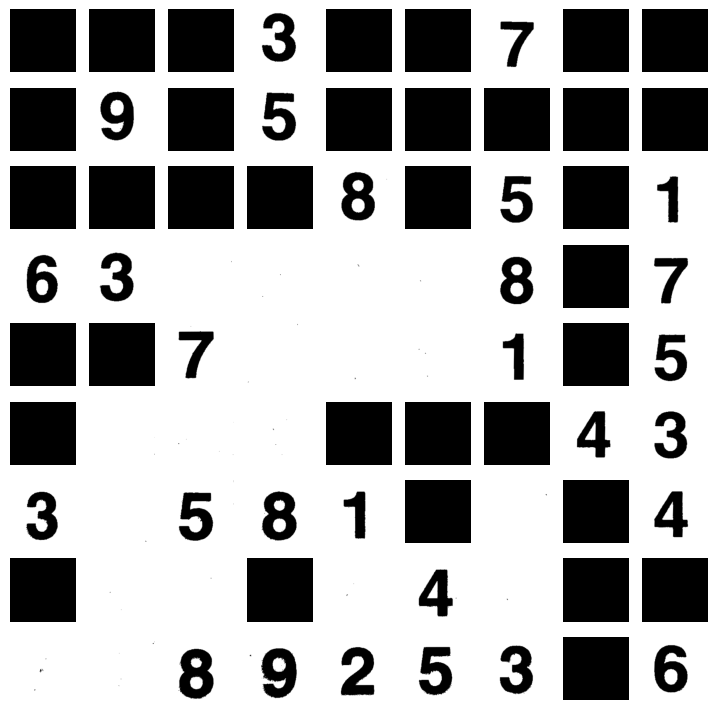

In [3]:
# Afficher chaque cellule dans leur configuration d'origine
cells_crop = [[None for _ in range(9)] for _ in range(9)]
fig, axs = plt.subplots(9, 9, figsize=(9, 9))
for i in range(9):
    for j in range(9):
        cells_crop[i][j] = crop_image(cells[i][j])
        axs[i, j].imshow(cells_crop[i][j], cmap='gray')
        axs[i, j].axis('off')
plt.show()

# Fonction qui décide si une case est vide ou non  

In [4]:
import numpy as np

def is_mostly_white(image, threshold=88):
    """
    Vérifie si une image binaire en niveaux de gris contient plus de 90% de pixels blancs.

    :param image: Image binaire en niveaux de gris.
    :param threshold: Pourcentage de pixels blancs nécessaire pour renvoyer True.
    :return: True si l'image contient plus de 90% de pixels blancs, False sinon.
    """
    # Vérifier si l'image est bien en niveaux de gris
    if len(image.shape) != 2:
        raise ValueError("L'image doit être en niveaux de gris")

    # Compter les pixels blancs
    total_pixels = image.size
    white_pixels = np.sum(image == 255)

    # Calculer le pourcentage de pixels blancs
    white_percentage = (white_pixels / total_pixels) * 100

    return white_percentage > threshold

# Détection des chiffres dans les cases

In [5]:
from ultralytics import YOLO

# Charger le modèle YOLOv8
model = YOLO('models/yolov8n_number.pt')

# Initialiser une grille pour stocker les résultats
detected_grid = [[0 for _ in range(9)] for _ in range(9)]

# Parcourir les cellules de la grille de Sudoku
for i in range(9):
    for j in range(9):
        if (is_mostly_white(cells_crop[i][j])):
            detected_grid[i][j] = 0
            continue
        
        # Effectuer la prédiction sur chaque cellule
        cells_rgb = cv2.cvtColor(cells_crop[i][j], cv2.COLOR_GRAY2BGR)
        results = model(cells_rgb)

        # Extraire le chiffre détecté
        for result in results:
            if result.boxes:
                for box in result.boxes:
                    detected_class = int(box.cls.item())
                    detected_grid[i][j] = detected_class



0: 640x640 1 3, 156.3ms
Speed: 2.3ms preprocess, 156.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 7, 114.1ms
Speed: 5.1ms preprocess, 114.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 9, 106.5ms
Speed: 3.2ms preprocess, 106.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 5, 139.6ms
Speed: 3.2ms preprocess, 139.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 8, 106.2ms
Speed: 3.1ms preprocess, 106.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 5, 98.5ms
Speed: 3.2ms preprocess, 98.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 1, 108.4ms
Speed: 2.6ms preprocess, 108.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 6, 125.2ms
Speed: 2.7ms preprocess, 125.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 3, 1

# Résultat

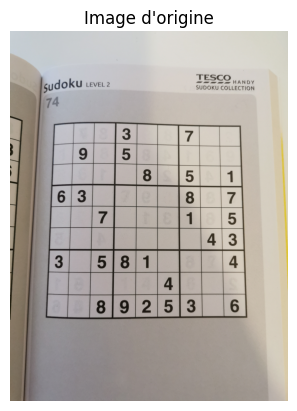

[[0, 0, 0, 3, 0, 0, 7, 0, 0],
 [0, 9, 0, 5, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 8, 0, 5, 0, 1],
 [6, 3, 0, 0, 0, 0, 8, 0, 7],
 [0, 0, 7, 0, 0, 0, 1, 0, 5],
 [0, 0, 0, 0, 0, 0, 0, 4, 3],
 [3, 0, 5, 8, 1, 0, 0, 0, 4],
 [0, 0, 0, 0, 0, 4, 0, 0, 0],
 [0, 0, 8, 9, 2, 5, 3, 0, 6]]

In [6]:
plot_image(image, "Image d'origine")
detected_grid